In [54]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

In [55]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [56]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

## Задание 1

In [57]:
df_1=df.groupby(['SeniorCitizen','Churn']).agg({'customerID':'nunique'}).reset_index()
df_1.columns = ['SeniorCitizen','Churn','count']
df_1

,SeniorCitizen,Churn,count
0,0,No,4508
1,0,Yes,1393
2,1,No,666
3,1,Yes,476


<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

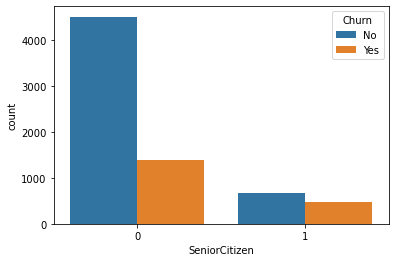

In [58]:
sns.barplot(data=df_1, x="SeniorCitizen", y="count" ,hue="Churn")

Или можно так с помощью plotly и еще подпишем название:

In [59]:
fig = px.histogram(
    data_frame=df,
    x="SeniorCitizen",
    color="Churn",
    title="Кол-во <b>ушедших</b> и <b>неушедших</b> клиентов в зависимости от флага пенсионера",
    histnorm="density",
)

fig.update_xaxes(categoryorder="total descending")

fig.show()

Пенсионеры уходят и перестают пользоваться услугами чаще. Возможно, мы как-то недостаточно хорошо работаем с этим сегментом клиентов и надо бы обратить на это внимание. Более показательно здесь было бы построить такую диаграмму, но по оси У показывая не абсолютное кол-во, а %, например. Или этот % выводить прямо текстом на столбике - тогда будем понимать и долю и абсолютное кол-во наблюдений. 

## Задание 2

Если у клиента подключен интернет, то ему доступны 6 дополнительных услуг, а именно: онлайн защита, онлайновое резервное копирование, защита устройства, наличие ТВ, наличие доступа к фильмам. Скорее всего, чтобы удержать клиента нам выгодно по-максимуму погружать его в нашу экосистему. Давайте посмотрим, зависит ли % оттекших клиентов от кол-ва услуг, которые у них были подключены (по клиентам, у кого подключен интернет) ? Одинаковая ли зависимость на разных типах интернета? Подберите тип визуализации и постройте график\диаграмму, который смог бы ответить на эти вопросы.

Возможное решение:

In [60]:
df['OnlineSecurity_flg']=df['OnlineSecurity'].map({'No': 0, 'Yes': 1})
df['OnlineBackup_flg']=df['OnlineBackup'].map({'No': 0, 'Yes': 1})
df['DeviceProtection_flg']=df['DeviceProtection'].map({'No': 0, 'Yes': 1})
df['TechSupport_flg']=df['TechSupport'].map({'No': 0, 'Yes': 1})
df['StreamingTV_flg']=df['StreamingTV'].map({'No': 0, 'Yes': 1})
df['StreamingMovies_flg']=df['StreamingMovies'].map({'No': 0, 'Yes': 1})
df['Churn_flg']=df['Churn'].map({'No': 0, 'Yes': 1})

df['N_services'] = (df['OnlineSecurity_flg'] + df['OnlineBackup_flg'] 
+ df['DeviceProtection_flg'] + df['TechSupport_flg'] 
+ df['StreamingTV_flg'] + df['StreamingMovies_flg'])

In [61]:
# делаем таблицу, где каждому типу интернета на каждое кол-во подключенных доп. услуг будет соотв-ть % ушедших клиентов
# и заодно посмотрим, а какое кол-во наблюдений имеем в каждой группе, можно ли вообще эти цифры сравнивать
table = df.groupby(['InternetService','N_services']).agg({'customerID':'nunique','Churn_flg':'mean'}).reset_index()
table

,InternetService,N_services,customerID,Churn_flg
0,DSL,0.0,294,0.411565
1,DSL,1.0,415,0.322892
2,DSL,2.0,454,0.202643
3,DSL,3.0,475,0.130526
4,DSL,4.0,359,0.091922
5,DSL,5.0,281,0.053381
6,DSL,6.0,143,0.013986
7,Fiber optic,0.0,399,0.604010
8,Fiber optic,1.0,551,0.558984
9,Fiber optic,2.0,579,0.480138


In [62]:
fig = go.Figure()

#  каждую из линий добавляем отдельно на график
fig.add_trace(go.Scatter(x=table.query('InternetService=="DSL"')['N_services'],
                         y=table.query('InternetService=="DSL"')['Churn_flg'],
                    mode='lines',
                    name='DSL'))

fig.add_trace(go.Scatter(x=table.query('InternetService=="Fiber optic"')['N_services'], 
                         y=table.query('InternetService=="Fiber optic"')['Churn_flg'],
                    mode='lines',
                    name='Fiber optic'))
fig.update_layout(
    width=800, # задаем размер графика
    height=600,
    title='Зависимость % ушедших клиентов от кол-ва подключенных доп услуг',
    xaxis_title='число подкл услуг',
    yaxis_title='% ушедших клиентов'
)
fig.show()

Чем больше опций было подключено к тарифу интернета, тем лояльнее клиент и меньше вероятность, что клиент уйдет. Однако тут есть еще 2 интересных наблюдения:
- у обоих кривых одинаковый наклон до 4 подкл. услуг, далее у клиентов с fiber optic резкое падение оттока при увеличении числа услуг. Интересно, с чем это связано и можно ли как-то эту информацию использовать для того, чтобы удерживать больше клиентов?
- кривая по клиентам с fiber optic всегда выше DSL: что-то с этим типом интернета не так, нужно разбираться, почему люди так активно от него отказываются?